# Load Python libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed train/test data

In [2]:
train = pd.read_pickle('../data/generated/preprocessed_train.pkl')
test = pd.read_pickle('../data/generated/preprocessed_test.pkl')

# EDA

In [3]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(5)

We have 650965 training rows and 72606 test rows.
We have 167 training columns and 166 test columns.


,ORDERED,PLATFORM_A,PLATFORM_B,PLATFORM_C,PLATFORM_D,SESSION_CNT,PRODUCT_ID,USER_ID_1,USER_ID_2,USER_ID_3,...,TENDENCY_7,TENDENCY_8,TENDENCY_9,TENDENCY_10,TENDENCY_11,TENDENCY_12,TENDENCY_13,TENDENCY_14,TENDENCY_15,TENDENCY_16
0,0,0,0,0,1,1,001C9D9B,8337B6FB,1,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2580,0.0030,NaN,NaN
1,0,0,0,0,1,1,001C9D9B,90D8AB70,1,nan,...,NaN,0.5000,NaN,NaN,NaN,NaN,0.5000,NaN,NaN,NaN
2,0,0,0,0,1,1,001C9D9B,ABC21E80,1,nan,...,NaN,0.0187,0.0047,NaN,NaN,NaN,0.0287,0.0055,NaN,NaN
3,0,0,0,0,1,1,001C9D9B,C17967D1,0,69EF2C8F,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0186,NaN,NaN,NaN
4,0,0,0,0,1,1,002B4BDE,AF145784,0,nan,...,NaN,0.0207,NaN,NaN,NaN,NaN,0.2805,0.0692,NaN,NaN


### train set의 상관 계수에 대한 히트맵

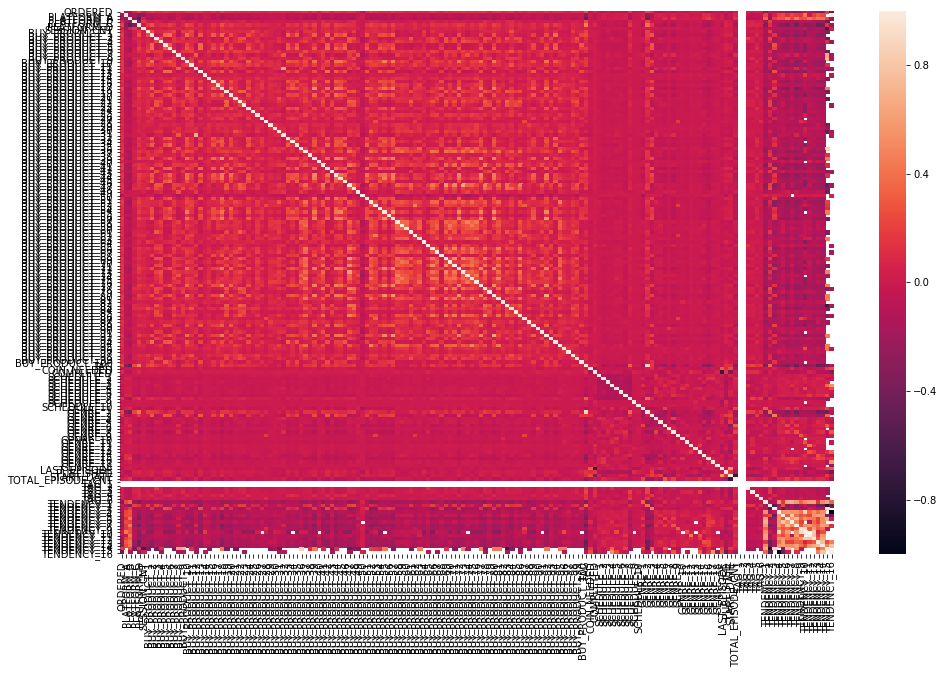

In [4]:
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

### 상관 계수가 같은 열을 제외하고 정렬

In [5]:
s = corr.unstack()
so = s.sort_values(kind='quicksort', ascending=False)
so = so.reset_index()
so[so['level_0'] != so['level_1']].head(20)

,level_0,level_1,0
161,TENDENCY_16,PLATFORM_A,0.986777
162,PLATFORM_A,TENDENCY_16,0.986777
163,TENDENCY_3,TENDENCY_15,0.918212
164,TENDENCY_15,TENDENCY_3,0.918212
165,TENDENCY_9,TENDENCY_10,0.901885
166,TENDENCY_10,TENDENCY_9,0.901885
167,GENRE_2,TAG,0.883358
168,TAG,GENRE_2,0.883358
169,TENDENCY_4,TENDENCY_10,0.860670
170,TENDENCY_10,TENDENCY_4,0.860670


### ORDERED label과의 상관 계수 확인

In [6]:
so[so['level_0'] == 'ORDERED'].head(20)

,level_0,level_1,0
158,ORDERED,ORDERED,1.000000
1477,ORDERED,TAG,0.240389
1721,ORDERED,GENRE_2,0.222300
2083,ORDERED,BUY_PRODUCT_18,0.201936
2129,ORDERED,PLATFORM_D,0.199042
2398,ORDERED,BUY_PRODUCT_52,0.186519
2666,ORDERED,TENDENCY_15,0.176384
2692,ORDERED,BUY_PRODUCT_2,0.175697
2760,ORDERED,BUY_PRODUCT_37,0.173585
2823,ORDERED,BUY_PRODUCT_41,0.170594


In [7]:
print('The PLATFORM_A has only two values {}.'.format(str(set(train.PLATFORM_A.unique()) | set(test.PLATFORM_A.unique()))))
print('The PLATFORM_B has only two values {}.'.format(str(set(train.PLATFORM_B.unique()) | set(test.PLATFORM_B.unique()))))
print('The PLATFORM_C has only two values {}.'.format(str(set(train.PLATFORM_C.unique()) | set(test.PLATFORM_C.unique()))))
print('The PLATFORM_D has only two values {}.'.format(str(set(train.PLATFORM_D.unique()) | set(test.PLATFORM_D.unique()))))
print('The TAG has only two values {}.'.format(str(set(train.TAG.unique()) | set(test.TAG.unique()))))
print('The COMPLETED has only two values {}.'.format(str(set(train.COMPLETED.unique()) | set(test.COMPLETED.unique()))))
print('The PUBLISHED has only two values {}.'.format(str(set(train.PUBLISHED.unique()) | set(test.PUBLISHED.unique()))))
print('The SCHEDULE_1 has only two values {}.'.format(str(set(train.SCHEDULE_1.unique()) | set(test.SCHEDULE_1.unique()))))
print('The SCHEDULE_2 has only two values {}.'.format(str(set(train.SCHEDULE_2.unique()) | set(test.SCHEDULE_2.unique()))))
print('The SCHEDULE_3 has only two values {}.'.format(str(set(train.SCHEDULE_3.unique()) | set(test.SCHEDULE_3.unique()))))
print('The SCHEDULE_4 has only two values {}.'.format(str(set(train.SCHEDULE_4.unique()) | set(test.SCHEDULE_4.unique()))))
print('The SCHEDULE_5 has only two values {}.'.format(str(set(train.SCHEDULE_5.unique()) | set(test.SCHEDULE_5.unique()))))
print('The SCHEDULE_6 has only two values {}.'.format(str(set(train.SCHEDULE_6.unique()) | set(test.SCHEDULE_6.unique()))))
print('The SCHEDULE_7 has only two values {}.'.format(str(set(train.SCHEDULE_7.unique()) | set(test.SCHEDULE_7.unique()))))
print('The SCHEDULE_8 has only two values {}.'.format(str(set(train.SCHEDULE_8.unique()) | set(test.SCHEDULE_8.unique()))))
print('The SCHEDULE_9 has only two values {}.'.format(str(set(train.SCHEDULE_9.unique()) | set(test.SCHEDULE_9.unique()))))
print('The SCHEDULE_10 has only two values {}.'.format(str(set(train.SCHEDULE_10.unique()) | set(test.SCHEDULE_10.unique()))))
print('The GENRE_1 has only two values {}.'.format(str(set(train.GENRE_1.unique()) | set(test.GENRE_1.unique()))))
print('The GENRE_2 has only two values {}.'.format(str(set(train.GENRE_2.unique()) | set(test.GENRE_2.unique()))))
print('The GENRE_3 has only two values {}.'.format(str(set(train.GENRE_3.unique()) | set(test.GENRE_3.unique()))))
print('The GENRE_4 has only two values {}.'.format(str(set(train.GENRE_4.unique()) | set(test.GENRE_4.unique()))))
print('The GENRE_5 has only two values {}.'.format(str(set(train.GENRE_5.unique()) | set(test.GENRE_5.unique()))))
print('The GENRE_6 has only two values {}.'.format(str(set(train.GENRE_6.unique()) | set(test.GENRE_6.unique()))))
print('The GENRE_7 has only two values {}.'.format(str(set(train.GENRE_7.unique()) | set(test.GENRE_7.unique()))))
print('The GENRE_8 has only two values {}.'.format(str(set(train.GENRE_8.unique()) | set(test.GENRE_8.unique()))))
print('The TAG_1 has only one values {}.'.format(str(set(train.TAG_1.unique()) | set(test.TAG_1.unique()))))
print('The TAG_2 has only one values {}.'.format(str(set(train.TAG_2.unique()) | set(test.TAG_2.unique()))))
print('The TAG_3 has only two values {}.'.format(str(set(train.TAG_3.unique()) | set(test.TAG_3.unique()))))
print('The TAG_4 has only two values {}.'.format(str(set(train.TAG_4.unique()) | set(test.TAG_4.unique()))))
print('The TAG_5 has only two values {}.'.format(str(set(train.TAG_5.unique()) | set(test.TAG_5.unique()))))
print('The TAG_6 has only two values {}.'.format(str(set(train.TAG_6.unique()) | set(test.TAG_6.unique()))))


The PLATFORM_A has only two values {0, 1}.
The PLATFORM_B has only two values {0, 1}.
The PLATFORM_C has only two values {0, 1}.
The PLATFORM_D has only two values {0, 1}.
The TAG has only two values {0, 1}.
The COMPLETED has only two values {0, 1}.
The PUBLISHED has only two values {0, 1}.
The SCHEDULE_1 has only two values {0, 1}.
The SCHEDULE_2 has only two values {0, 1}.
The SCHEDULE_3 has only two values {0, 1}.
The SCHEDULE_4 has only two values {0, 1}.
The SCHEDULE_5 has only two values {0, 1}.
The SCHEDULE_6 has only two values {0, 1}.
The SCHEDULE_7 has only two values {0, 1}.
The SCHEDULE_8 has only two values {0, 1}.
The SCHEDULE_9 has only two values {0, 1}.
The SCHEDULE_10 has only two values {0, 1}.
The GENRE_1 has only two values {0, 1}.
The GENRE_2 has only two values {0, 1}.
The GENRE_3 has only two values {0, 1}.
The GENRE_4 has only two values {0, 1}.
The GENRE_5 has only two values {0, 1}.
The GENRE_6 has only two values {0, 1}.
The GENRE_7 has only two values {0, 1

# Feature engineering - User

In [8]:
usr1 = train.groupby([train.USER_ID_1, train.USER_ID_2, train.USER_ID_3]).agg({'SESSION_CNT': ['sum', 'mean']})
usr1.columns = usr1.columns.droplevel(0)
usr1.columns = ['USR_SESSION_CNT_SUM', 'USR_SESSION_CNT_MEAN']
usr1.reset_index(inplace=True)
usr1.head(10)

,USER_ID_1,USER_ID_2,USER_ID_3,USR_SESSION_CNT_SUM,USR_SESSION_CNT_MEAN
0,0001FFE4,0,nan,5449.0,75.680556
1,0001FFE4,1,1CBBA69E,137.0,137.000000
2,0001FFE4,1,2022E1C2,23.0,23.000000
3,0001FFE4,1,3293EDFD,4.0,2.000000
4,0001FFE4,1,391AD84C,125.0,41.666667
5,0001FFE4,1,4803360F,11.0,5.500000
6,0001FFE4,1,55F27785,50.0,10.000000
7,0001FFE4,1,63F6DF08,195.0,195.000000
8,0001FFE4,1,8A84985F,6.0,6.000000
9,0001FFE4,1,8DB6ABA4,2316.0,165.428571


In [9]:
usr2 = train.groupby([train.USER_ID_1, train.USER_ID_2]).agg({'TENDENCY_1': ['sum', 'mean'],
                                                             'TENDENCY_2': ['sum', 'mean'],
                                                             'TENDENCY_3': ['sum', 'mean'],
                                                             'TENDENCY_4': ['sum', 'mean'],
                                                             'TENDENCY_5': ['sum', 'mean'],
                                                             'TENDENCY_6': ['sum', 'mean'],
                                                             'TENDENCY_7': ['sum', 'mean'],
                                                             'TENDENCY_8': ['sum', 'mean'],
                                                             'TENDENCY_9': ['sum', 'mean'],
                                                             'TENDENCY_10': ['sum', 'mean'],
                                                             'TENDENCY_11': ['sum', 'mean'],
                                                             'TENDENCY_12': ['sum', 'mean'],
                                                             'TENDENCY_13': ['sum', 'mean'],
                                                             'TENDENCY_14': ['sum', 'mean'],
                                                             'TENDENCY_15': ['sum', 'mean'],
                                                             'TENDENCY_16': ['sum', 'mean']})
usr2.columns = usr2.columns.droplevel(0)
usr2.columns = ['USR_TENDENCY_1_SUM', 'USR_TENDENCY_1_MEAN',
                        'USR_TENDENCY_2_SUM', 'USR_TENDENCY_2_MEAN',
                        'USR_TENDENCY_3_SUM', 'USR_TENDENCY_3_MEAN',
                        'USR_TENDENCY_4_SUM', 'USR_TENDENCY_4_MEAN',
                        'USR_TENDENCY_5_SUM', 'USR_TENDENCY_5_MEAN',
                        'USR_TENDENCY_6_SUM', 'USR_TENDENCY_6_MEAN',
                        'USR_TENDENCY_7_SUM', 'USR_TENDENCY_7_MEAN',
                        'USR_TENDENCY_8_SUM', 'USR_TENDENCY_8_MEAN',
                        'USR_TENDENCY_9_SUM', 'USR_TENDENCY_9_MEAN',
                        'USR_TENDENCY_10_SUM', 'USR_TENDENCY_10_MEAN',
                        'USR_TENDENCY_11_SUM', 'USR_TENDENCY_11_MEAN',
                        'USR_TENDENCY_12_SUM', 'USR_TENDENCY_12_MEAN',
                        'USR_TENDENCY_13_SUM', 'USR_TENDENCY_13_MEAN',
                        'USR_TENDENCY_14_SUM', 'USR_TENDENCY_14_MEAN',
                        'USR_TENDENCY_15_SUM', 'USR_TENDENCY_15_MEAN',
                        'USR_TENDENCY_16_SUM', 'USR_TENDENCY_16_MEAN']
usr2.reset_index(inplace=True)
usr2.head(10)

,USER_ID_1,USER_ID_2,USR_TENDENCY_1_SUM,USR_TENDENCY_1_MEAN,USR_TENDENCY_2_SUM,USR_TENDENCY_2_MEAN,USR_TENDENCY_3_SUM,USR_TENDENCY_3_MEAN,USR_TENDENCY_4_SUM,USR_TENDENCY_4_MEAN,...,USR_TENDENCY_12_SUM,USR_TENDENCY_12_MEAN,USR_TENDENCY_13_SUM,USR_TENDENCY_13_MEAN,USR_TENDENCY_14_SUM,USR_TENDENCY_14_MEAN,USR_TENDENCY_15_SUM,USR_TENDENCY_15_MEAN,USR_TENDENCY_16_SUM,USR_TENDENCY_16_MEAN
0,0001FFE4,0,NaN,NaN,14.430300,0.412294,20.300301,0.414292,NaN,NaN,...,NaN,NaN,21.509800,0.430196,3.174100,0.126964,NaN,NaN,NaN,NaN
1,0001FFE4,1,9.945601,0.081521,260.378296,0.476883,105.631996,0.246804,1.6623,0.023087,...,1.8596,0.024468,92.885201,0.166760,25.563900,0.059451,NaN,NaN,NaN,NaN
2,0033C556,0,4.282200,0.475800,1.451100,0.120925,9.464800,0.411513,0.1188,0.039600,...,NaN,NaN,13.267500,0.358581,6.242400,0.201368,NaN,NaN,NaN,NaN
3,0033C556,1,5.795300,0.170450,87.436798,0.549917,30.823700,0.308237,0.6752,0.048229,...,NaN,NaN,25.507401,0.150931,6.436700,0.070733,NaN,NaN,NaN,NaN
4,009405B4,0,4.012500,0.191071,0.333100,0.083275,6.755600,0.375311,0.2802,0.017513,...,NaN,NaN,15.428800,0.314873,4.021600,0.103118,NaN,NaN,NaN,NaN
5,009405B4,1,5.981000,0.186906,99.290199,0.459677,59.687901,0.351105,0.4582,0.014781,...,NaN,NaN,39.141602,0.190008,10.228200,0.077486,NaN,NaN,NaN,NaN
6,00CE6679,0,6.668800,0.392282,8.499000,0.169980,30.566000,0.477594,1.9445,0.277786,...,NaN,NaN,66.696701,0.479832,20.554199,0.190317,NaN,NaN,NaN,NaN
7,00CE6679,1,3.947900,0.131597,61.305500,0.367099,56.055698,0.371230,0.1256,0.011418,...,NaN,NaN,17.792900,0.112613,3.293900,0.041695,NaN,NaN,NaN,NaN
8,00FB330F,0,3.942900,0.262860,5.818200,0.181819,18.316099,0.482003,0.1737,0.057900,...,NaN,NaN,48.642799,0.491341,15.728000,0.189494,NaN,NaN,NaN,NaN
9,00FB330F,1,5.471900,0.218876,44.697498,0.460799,26.610201,0.302389,0.3969,0.132300,...,NaN,NaN,18.558201,0.168711,6.800200,0.089476,NaN,NaN,NaN,NaN


In [10]:
usr = usr1.merge(usr2, on=['USER_ID_1', 'USER_ID_2'])
usr.head(10)

,USER_ID_1,USER_ID_2,USER_ID_3,USR_SESSION_CNT_SUM,USR_SESSION_CNT_MEAN,USR_TENDENCY_1_SUM,USR_TENDENCY_1_MEAN,USR_TENDENCY_2_SUM,USR_TENDENCY_2_MEAN,USR_TENDENCY_3_SUM,...,USR_TENDENCY_12_SUM,USR_TENDENCY_12_MEAN,USR_TENDENCY_13_SUM,USR_TENDENCY_13_MEAN,USR_TENDENCY_14_SUM,USR_TENDENCY_14_MEAN,USR_TENDENCY_15_SUM,USR_TENDENCY_15_MEAN,USR_TENDENCY_16_SUM,USR_TENDENCY_16_MEAN
0,0001FFE4,0,nan,5449.0,75.680556,NaN,NaN,14.430300,0.412294,20.300301,...,NaN,NaN,21.509800,0.430196,3.1741,0.126964,NaN,NaN,NaN,NaN
1,0001FFE4,1,1CBBA69E,137.0,137.000000,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
2,0001FFE4,1,2022E1C2,23.0,23.000000,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
3,0001FFE4,1,3293EDFD,4.0,2.000000,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
4,0001FFE4,1,391AD84C,125.0,41.666667,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
5,0001FFE4,1,4803360F,11.0,5.500000,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
6,0001FFE4,1,55F27785,50.0,10.000000,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
7,0001FFE4,1,63F6DF08,195.0,195.000000,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
8,0001FFE4,1,8A84985F,6.0,6.000000,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN
9,0001FFE4,1,8DB6ABA4,2316.0,165.428571,9.945601,0.081521,260.378296,0.476883,105.631996,...,1.8596,0.024468,92.885201,0.166760,25.5639,0.059451,NaN,NaN,NaN,NaN


# Feature Engineering - Product

In [11]:
prd = train.groupby([train.PRODUCT_ID]).agg({'LAST_EPISODE': ['sum', 'mean'],
                                              'START_DATE': ['sum', 'mean'],
                                              'TOTAL_EPISODE_CNT': ['sum', 'mean']})
prd.columns = prd.columns.droplevel(0)
prd.columns = ['PRD_LAST_EPISODE_SUM', 'PRD_LAST_EPISODE_MEAN',
                'PRD_START_DATE_SUM', 'PRD_START_DATE_MEAN',
                'PRD_TOTAL_EPISODE_CNT_SUM', 'PRD_TOTAL_EPISODE_CNT_MEAN']
prd.reset_index(inplace=True)
prd.head(10)

,PRODUCT_ID,PRD_LAST_EPISODE_SUM,PRD_LAST_EPISODE_MEAN,PRD_START_DATE_SUM,PRD_START_DATE_MEAN,PRD_TOTAL_EPISODE_CNT_SUM,PRD_TOTAL_EPISODE_CNT_MEAN
0,001C9D9B,5168.0,19,5168.0,19,272.0,1
1,002B4BDE,11020.0,19,10440.0,18,580.0,1
2,0030E221,80.0,16,80.0,16,0.0,0
3,00343701,56.0,14,56.0,14,0.0,0
4,003C31DA,48.0,16,48.0,16,6.0,2
5,004259EF,14.0,14,14.0,14,9.0,9
6,004D740D,15.0,15,15.0,15,0.0,0
7,00545B4F,2413.0,19,2413.0,19,0.0,0
8,00548AD2,38.0,19,38.0,19,0.0,0
9,00563F3B,16.0,16,16.0,16,1.0,1


# Feature Engineering - User x Product

In [12]:
usr_prd = train.groupby([train.USER_ID_1, train.USER_ID_2, train.USER_ID_3, train.PRODUCT_ID]).agg({
    'USER_ID_1': 'size',
    'ORDERED': 'sum'})
#usr_prd.columns = usr_prd.columns.droplevel(0)
usr_prd.columns = ['UP_VIEW_CNT', 'UP_ORDERED_SUM']
usr_prd['UP_ORDERED_RATIO'] = pd.Series(usr_prd.UP_ORDERED_SUM / usr_prd.UP_VIEW_CNT).astype(np.float32)
usr_prd.reset_index(inplace=True)
usr_prd.head(10)

,USER_ID_1,USER_ID_2,USER_ID_3,PRODUCT_ID,UP_VIEW_CNT,UP_ORDERED_SUM,UP_ORDERED_RATIO
0,0001FFE4,0,nan,00A49090,8,6.0,0.75
1,0001FFE4,0,nan,02824AF6,1,0.0,0.00
2,0001FFE4,0,nan,0757A410,1,0.0,0.00
3,0001FFE4,0,nan,0AC58E19,1,0.0,0.00
4,0001FFE4,0,nan,0E01938F,1,0.0,0.00
5,0001FFE4,0,nan,0F130215,1,0.0,0.00
6,0001FFE4,0,nan,11395443,1,0.0,0.00
7,0001FFE4,0,nan,12AEA340,1,0.0,0.00
8,0001FFE4,0,nan,1679091C,1,0.0,0.00
9,0001FFE4,0,nan,18F35B76,2,2.0,1.00
